In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from binance.client import Client
from utils import load_binance_api_key
API_Key, Secret_Key = load_binance_api_key()
from rich.console import Console
from IPython.display import display
console = Console()

FileNotFoundError: Could not find [api_key/account.json].
Steps to fix.
1. Copy the [api_key/example.json] file to [api_key/account.json]
2. Apply a api key from binance and fill the info in [api_key/account.json]


In [35]:
client = Client(API_Key, Secret_Key)

X='ETH'
Y='USDT'
symbol = X + Y

ticker = client.get_ticker(symbol=X+Y)
lastPrice = float(ticker['lastPrice'])
print(datetime.utcfromtimestamp(ticker['closeTime']/1000), lastPrice)

2021-04-13 17:27:13.622000 2293.32


In [36]:
def firstSec(date):
    return int(datetime.strptime(date + " 00:00:00", "%Y-%m-%d %H:%M:%S").timestamp()*1000)
def lastSec(date):
    return int(datetime.strptime(date + " 23:59:00", "%Y-%m-%d %H:%M:%S").timestamp()*1000)

def klines2df(raw_klines):
    klines = []
    for T1,O,H,L,C,volume,T2,quotaVolume,tradeNumbers,takerBuyBaseVolume,takerBuyQuoteVolume,_ in raw_klines:
        timeOpen = int(T1/1000)
        strOpen = datetime.fromtimestamp(T1/1000).strftime("%Y-%m-%d %H:%M:%S")
        O,H,L,C = float(O), float(H), float(L), float(C)
        klines.append([timeOpen, strOpen, O, H, L, C, 
            float(volume),float(takerBuyBaseVolume),float(takerBuyQuoteVolume)])
        
    df = pd.DataFrame(klines)
    df.columns =['timeOpen', 'strOpen', 'open', 'high', 'low', 'close',
                 'volume','takerBuyBaseVolume','takerBuyQuoteVolume']
    return df

def get_historical_klines_df(symbol, start, end, peroid):
    INTERVAL = {
        '1min': Client.KLINE_INTERVAL_1MINUTE,
        '15min': Client.KLINE_INTERVAL_15MINUTE,
    }
    raw_klines = client.get_historical_klines(symbol, INTERVAL[peroid], start, end)
    print(len(raw_klines))
    return klines2df(raw_klines)

def get_recent_klines_1MINUTE(symbol, limit=1):
    raw_klines = client.get_klines(symbol, interval=Client.KLINE_INTERVAL_1MINUTE, limit=limit)
    return raw_klines

In [37]:
df = get_historical_klines_df(symbol, firstSec('2021-03-01'), lastSec('2021-03-30'), '15min')

2874


In [38]:
df

,timeOpen,strOpen,open,high,low,close,volume,takerBuyBaseVolume,takerBuyQuoteVolume
0,1614528000,2021-03-01 00:00:00,1318.29,1346.87,1301.71,1336.49,49977.01899,23637.83032,3.142400e+07
1,1614528900,2021-03-01 00:15:00,1336.58,1355.00,1333.18,1338.90,32563.21173,17766.63352,2.393307e+07
2,1614529800,2021-03-01 00:30:00,1339.05,1368.00,1337.27,1359.40,21098.80283,11565.58159,1.568553e+07
3,1614530700,2021-03-01 00:45:00,1359.29,1363.46,1345.26,1346.86,27367.00947,19262.14021,2.603331e+07
4,1614531600,2021-03-01 01:00:00,1346.86,1351.29,1333.93,1345.39,23792.95020,14712.40288,1.972020e+07
...,...,...,...,...,...,...,...,...,...
2869,1617115500,2021-03-30 22:45:00,1840.93,1842.32,1834.99,1836.94,5024.08731,2505.19357,4.606469e+06
2870,1617116400,2021-03-30 23:00:00,1836.93,1840.65,1834.50,1839.37,5209.20694,2904.02576,5.338833e+06
2871,1617117300,2021-03-30 23:15:00,1839.36,1840.65,1828.76,1831.13,8645.55635,5259.50043,9.662211e+06
2872,1617118200,2021-03-30 23:30:00,1831.21,1833.83,1829.34,1832.21,5972.66626,1990.11689,3.644716e+06


In [66]:
RSI6 = np.ones_like(df['close']) * 0.5
tickDelta = df['close'] - df['open']
N = tickDelta.shape[0]
RSI_N = 12
for t in range(RSI_N, N):
    upAmount, downAmount = 0, 0
    for i in range(0, RSI_N):
        histPrice = tickDelta[t - i]
        if histPrice > 0:
            upAmount += np.abs(histPrice)
        else:
            downAmount += np.abs(histPrice)
    if upAmount + downAmount != 0:
        RSI6[t] = upAmount / (upAmount + downAmount)
        RSI6[t] = np.clip(RSI6[t], 0, 1)

In [75]:
price = (df['close'] + df['open'])/2
holdingCoin = False
buyPrice = 0
earn = 0
earnHistory = []
for t in range(N):
    if holdingCoin:
        rate = (price[t] - buyPrice) / buyPrice
        if rate > 0.05 or rate < -0.05:
            holdingCoin = False
            earn += (price[t] - buyPrice)
            
    if RSI6[t] < 0.1 and not holdingCoin:
        buyPrice = price[t]
        holdingCoin = True
        
    if RSI6[t] > 0.5 and holdingCoin:
        holdingCoin = False
        earn += (price[t] - buyPrice)
    
    earnHistory.append(earn)
earnHistory = np.array(earnHistory)

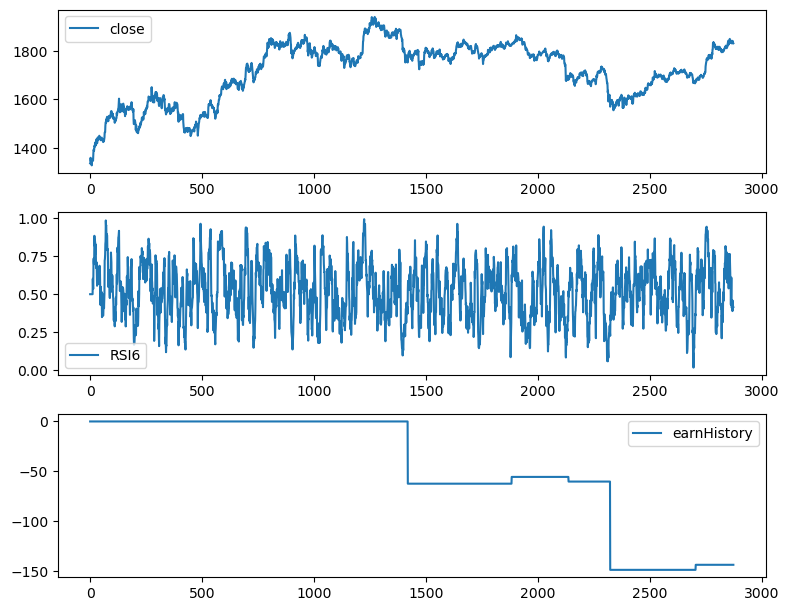

In [76]:
fig = plt.figure(figsize=(8,8), dpi=100, facecolor='w', edgecolor='k')
ax=plt.subplot(4,1,1); plt.plot(range(N), df['close'], label='close'); plt.legend()
ax=plt.subplot(4,1,2); plt.plot(range(N), RSI6, label='RSI6'); plt.legend()
ax=plt.subplot(4,1,3); plt.plot(range(N), earnHistory, label='earnHistory'); plt.legend()
plt.tight_layout();plt.show()